In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, MiniBatchKMeans
from sklearn.cluster import AffinityPropagation, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.decomposition import PCA

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='internal gelsd'
)

In [2]:
boston2013 = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv')
boston2013.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.900,W1,NaN,...,9,3.470,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.500,1,NaN,...,5,5.070,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.370,2,NaN,...,1,4.980,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.430,W2,NaN,...,5,3.380,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.220,W3,NaN,...,3,3.330,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [3]:
boston2013.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000
mean,41.638,1100.967,208.159,8429.373,7.947,4351.685
std,10.351,942.115,23.744,5052.024,0.906,2772.398
min,18.000,1.000,85.530,1.000,3.270,1.000
25%,34.000,363.000,191.727,4061.750,7.320,2032.750
50%,42.000,842.000,209.225,8247.500,7.980,4113.500
75%,49.000,1560.000,225.230,12662.250,8.600,6316.000
max,80.000,3834.000,284.230,17598.000,10.850,10648.000


In [4]:
# Check dtypes.
boston2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


## Data Cleaning

In [5]:
# View missing data.
boston2013.isnull().sum()

25k              0
age              0
name             0
division         0
10k              0
gender           0
half             0
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k              0
5k               0
genderdiv        0
20k              0
35k              0
city             1
40k              0
dtype: int64

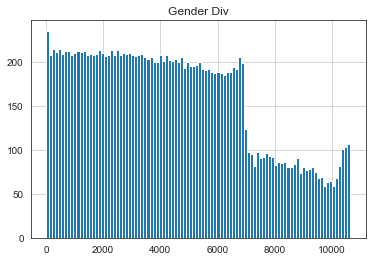

In [6]:
boston2013['genderdiv'].hist(bins=100)
plt.title('Gender Div')
plt.show()

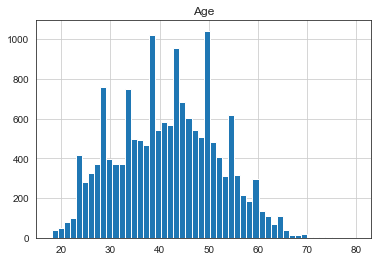

In [7]:
boston2013['age'].hist(bins=50)
plt.title('Age')
plt.show()

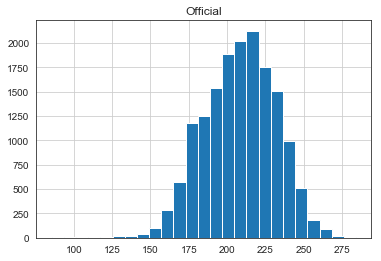

In [8]:
boston2013['official'].hist(bins=25)
plt.title('Official')
plt.show()

In [9]:
# Drop columns that are not relevant.
boston2013 = boston2013.drop(['name', 'division', 'bib', 'ctz', 'country', 'state', 'city'], 1)

In [10]:
# Rearrange columns.
boston2013 = boston2013[['age', 'gender', '5k', '10k', '20k', 'half', '25k', '30k',
                        '35k', '40k', 'official', 'pace']]

In [11]:
# Binarize 'gender' column as 0=female, 1=male.
boston2013['gender'].replace(('F', 'M'), (0, 1), inplace=True)

In [12]:
# Drop other missing data.
boston2013 = boston2013.dropna()

In [13]:
# Remove hyphens from missing values.
boston2013 = boston2013.replace(to_replace='-',value='0')

In [14]:
# Convert race times to numeric values.
columns = boston2013[['5k','10k','20k','25k','half','30k','35k','40k','age','official','pace']]

for column in columns: 
    boston2013[column] = pd.to_numeric(boston2013[column], errors='coerce')

In [15]:
# See data frame format.
boston2013.head()

,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
0,28,1,8.900,18.180,38.800,40.930,49.870,62.070,74.730,85.550,90.900,3.470
1,30,1,15.900,30.900,61.520,64.900,77.270,92.970,108.780,124.770,132.500,5.070
2,23,1,15.930,30.900,61.530,64.920,77.230,92.720,108.680,123.780,130.370,4.980
3,32,1,8.980,18.730,39.880,42.000,50.500,61.350,73.000,83.430,88.430,3.380
4,39,1,8.920,18.180,38.550,40.570,48.750,59.920,71.680,81.880,87.220,3.330


In [16]:
# View measures of central tendency.
boston2013.describe()

,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000,16164.000
mean,41.638,0.599,23.329,46.655,93.953,99.133,118.036,143.425,169.750,196.352,208.159,7.947
std,10.351,0.490,2.879,5.254,10.410,10.965,13.423,16.345,19.928,23.230,23.744,0.906
min,18.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,85.530,3.270
25%,34.000,0.000,21.700,43.200,86.765,91.530,108.900,132.170,156.345,180.900,191.727,7.320
50%,42.000,1.000,23.630,47.170,94.870,100.080,119.150,144.700,171.210,197.780,209.225,7.980
75%,49.000,1.000,25.180,50.280,101.270,106.850,127.320,154.780,183.570,212.600,225.230,8.600
max,80.000,1.000,33.220,66.680,131.720,138.670,163.620,195.870,229.500,268.400,284.230,10.850


We can glean a wealth of knowledge from these figures. First of all, approximately 60% of the runners are male, compared with 40% female. The age range is huge:  the youngest runner is 18 and the oldest is 80. It also appears that the best time is 85 minutes(?), which I would imagine would have to be a record! 

In [17]:
# Double-check dtypes.
boston2013.dtypes

age           int64
gender        int64
5k          float64
10k         float64
20k         float64
half        float64
25k         float64
30k         float64
35k         float64
40k         float64
official    float64
pace        float64
dtype: object

In [18]:
# Set and normalize X.
X = boston2013.loc[:, ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official']]
X_norm = normalize(X)
print(len(X_norm))

# Run PCA.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
print(len(X_pca))
ypred = pd.DataFrame()

16164
16164


In [19]:
# Separate data into four equal sets for cross-validation.
# Divide into two sets.
Xhalf1, Xhalf2, X_pca_1, X_pca_2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=15)

# Divide into four sets.
X1, X2, X_pca1, X_pca2 = train_test_split(
    Xhalf1,
    X_pca_1,
    test_size=0.5,
    random_state=15)
X3, X4, X_pca3, X_pca4 = train_test_split(
    Xhalf2,
    X_pca_1,
    test_size=0.5,
    random_state=15)

# Check the length of each set.
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

4041 4041
4041 4041
4041 4041
4041 4041


## Models and Plotting

KMeans 
 col_0      0   1
row_0           
0      16150   0
1          0  14 

clusters: 2	 silhouette: 0.9809844131876659

MiniBatch 
 col_0     0      1
row_0             
0      3178   1076
1         0  11910 

clusters: 2	 silhouette: 0.6203998321036954

MeanShift 
 col_0     0   1   2   3   4    5   6   7   8   9   ...  23  24  25  26  27  \
row_0                                              ...                       
0      15192   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   
1          0   8   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   
2          0   0   8   0   0    0   0   0   0   0  ...   0   0   0   0   0   
3          0   0   0   8   0    0   0   0   0   0  ...   0   0   0   0   0   
4          0   0   0   0  16    0   0   0   0   0  ...   0   0   0   0   0   
5          0   0   0   0   0  185   0   0   0   0  ...   0   0   0   0   0   
6          0   0   0   0   0    0   7   0   0   0  ...   0   0   0   0   0   
7          0   0   0   0   

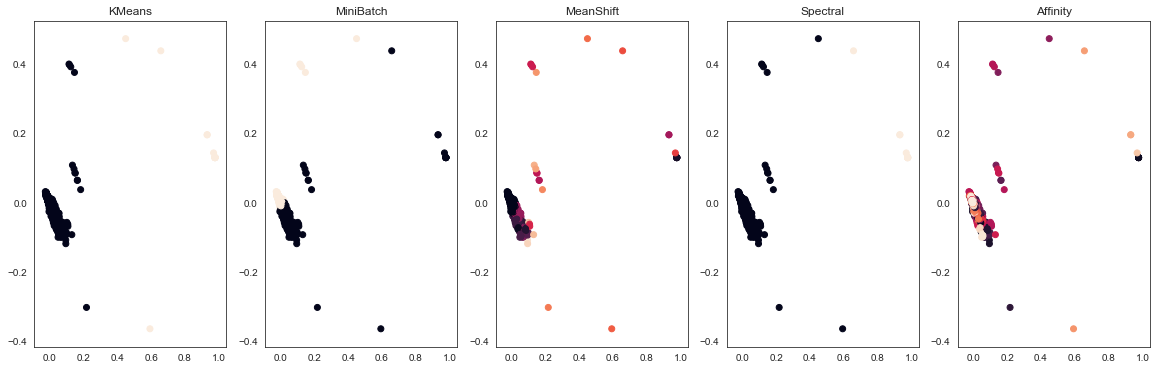

In [20]:
# Establish variables.
fig, ax = plt.subplots(1,5, figsize=(20,6))
models = []
names = []
plot_nums = []
silhouettes = []
clust=[]

# Create plotting function.
def plotting(plot_num,labels,ypred):    
        silhouettes.append(silhouette)
        if plot_num<=2:
            ax[plot_num].scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
            silhouettes.append(silhouette)
            if plot_num==2:
                clusters=len(np.unique(labels))
                clust.append(clusters)
        elif plot_num==3:
            ax[plot_num].scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
            clusters=len(np.unique(labels))
            clust.append(clusters)
        else:
            ax[plot_num].scatter(X_pca[:, 0], X_pca[:, 1], c=ypred)
            silhouettes.append(silhouette)
            cluster_centers_indices = model.cluster_centers_indices_
            n_clusters=len(cluster_centers_indices)
            clust.append(n_clusters)
            

#for clusters in range(2,5):
clusters = 2
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)
models.append((0, 'KMeans', KMeans(n_clusters=clusters, init='k-means++', random_state=42)))
models.append((1, 'MiniBatch', MiniBatchKMeans(init='random', n_clusters=clusters, batch_size=500)))
models.append((2, 'MeanShift', MeanShift(bandwidth=bandwidth, bin_seeding=True)))
models.append((3, 'Spectral', SpectralClustering(n_clusters=clusters)))
models.append((4, 'Affinity', AffinityPropagation()))

for plot_num, name, model in models:  
    names.append(name)
    
    model.fit(X_pca)
    
    labels = model.labels_
    ypred = model.fit_predict(X_pca)
    
    silhouette = metrics.silhouette_score(X_pca, labels, metric='euclidean')
    silhouettes.append(silhouette)
    ax[plot_num].set_title(name)
    plotting(plot_num, labels, ypred) 
    
    print(name,'\n', pd.crosstab(ypred, labels), '\n')
    print('clusters: {}\t silhouette: {}\n'.format(clusters, silhouette))

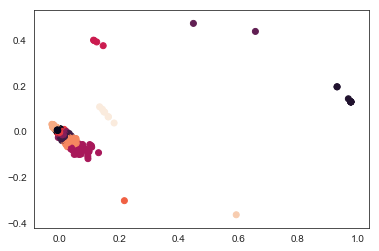

In [21]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=13, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [22]:
# Re-run KMeans and extract cluster information.
model = KMeans(n_clusters=16, random_state=15).fit(X_pca)

# Extract cluster assignments for each data point.
labels = model.labels_

boston2013['clusters'] = labels

In [23]:
boston2013_clusters = boston2013.groupby(['clusters'], as_index=False).mean()
print(boston2013_clusters)

    clusters    age  gender     5k    10k     20k    half     25k     30k  \
0          0 40.917   0.576 23.362 46.597  93.257  98.328 116.626 140.640   
1          1 40.182   0.455  7.249  9.738   0.000   0.000   0.000   0.000   
2          2 42.153   0.753 22.861 45.962  94.118  99.425 119.532 147.488   
3          3 42.380   0.583 23.403 46.896  94.948 100.235 119.768 146.132   
4          4 39.500   0.500 24.185 48.420  97.735 103.110   0.000  75.290   
5          5 41.181   0.847 22.458 45.198  92.686  97.977 118.286 147.318   
6          6 39.500   0.750 22.262 44.425  89.032  93.897 111.540 135.355   
7          7 45.429   0.571 21.010 50.031 102.023 108.240 130.341 161.281   
8          8 65.000   1.000  0.000  0.000   0.000   0.000   0.000   0.000   
9          9 38.268   0.732 21.457 42.882  84.528  87.141  91.424 129.896   
10        10 42.557   0.572 23.343 46.831  94.372  99.575 118.628 144.109   
11        11 42.239   0.683 23.058 46.224  94.109  99.379 119.142 146.136   

In [24]:
boston2013_clusters.sort_values(by='official')

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
6,6,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
12,12,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
0,0,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
14,14,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
10,10,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
3,3,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
4,4,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
8,8,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280
11,11,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
1,1,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455


In [25]:
boston2013_clusters.sort_values(by='gender')

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
1,1,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
4,4,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
14,14,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
12,12,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
7,7,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030
10,10,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
0,0,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
3,3,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
11,11,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
9,9,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005


In [26]:
boston2013_clusters.sort_values(by='age')

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
15,15,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720
9,9,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005
12,12,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
4,4,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
6,6,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
13,13,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061
1,1,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
0,0,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
5,5,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
14,14,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821


In [27]:
cluster00 = boston2013_clusters[boston2013_clusters['clusters']==0]
cluster00.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,0.000,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,0.000,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
25%,0.000,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
50%,0.000,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
75%,0.000,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
max,0.000,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612


In [28]:
cluster01 = boston2013_clusters[boston2013_clusters['clusters']==1]
cluster01.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,1.000,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,1.000,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
25%,1.000,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
50%,1.000,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
75%,1.000,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455
max,1.000,40.182,0.455,7.249,9.738,0.000,0.000,0.000,0.000,0.000,0.000,221.469,8.455


In [29]:
cluster02 = boston2013_clusters[boston2013_clusters['clusters']==2]
cluster02.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,2.000,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,2.000,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565
25%,2.000,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565
50%,2.000,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565
75%,2.000,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565
max,2.000,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565


In [30]:
cluster03 = boston2013_clusters[boston2013_clusters['clusters']==3]
cluster03.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,3.000,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,3.000,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
25%,3.000,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
50%,3.000,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
75%,3.000,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
max,3.000,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194


In [31]:
cluster04 = boston2013_clusters[boston2013_clusters['clusters']==4]
cluster04.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,4.000,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,4.000,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
25%,4.000,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
50%,4.000,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
75%,4.000,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250
max,4.000,39.500,0.500,24.185,48.420,97.735,103.110,0.000,75.290,0.000,0.000,216.105,8.250


In [32]:
cluster05 = boston2013_clusters[boston2013_clusters['clusters']==5]
cluster05.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,5.000,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,5.000,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
25%,5.000,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
50%,5.000,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
75%,5.000,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
max,5.000,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780


In [33]:
cluster06 = boston2013_clusters[boston2013_clusters['clusters']==6]
cluster06.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,6.000,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,6.000,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
25%,6.000,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
50%,6.000,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
75%,6.000,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388
max,6.000,39.500,0.750,22.262,44.425,89.032,93.897,111.540,135.355,159.577,0.000,193.430,7.388


In [34]:
cluster07 = boston2013_clusters[boston2013_clusters['clusters']==7]
cluster07.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,7.000,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,7.000,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030
25%,7.000,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030
50%,7.000,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030
75%,7.000,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030
max,7.000,45.429,0.571,21.010,50.031,102.023,108.240,130.341,161.281,0.000,223.586,236.570,9.030


In [35]:
cluster08 = boston2013_clusters[boston2013_clusters['clusters']==8]
cluster08.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,8.000,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,8.000,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280
25%,8.000,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280
50%,8.000,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280
75%,8.000,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280
max,8.000,65.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,202.370,216.980,8.280


In [36]:
cluster09 = boston2013_clusters[boston2013_clusters['clusters']==9]
cluster09.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,9.000,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,9.000,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005
25%,9.000,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005
50%,9.000,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005
75%,9.000,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005
max,9.000,38.268,0.732,21.457,42.882,84.528,87.141,91.424,129.896,178.222,220.710,235.871,9.005


In [37]:
cluster10 = boston2013_clusters[boston2013_clusters['clusters']==10]
cluster10.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,10.000,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,10.000,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
25%,10.000,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
50%,10.000,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
75%,10.000,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
max,10.000,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976


In [38]:
cluster11 = boston2013_clusters[boston2013_clusters['clusters']==11]
cluster11.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,11.000,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,11.000,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
25%,11.000,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
50%,11.000,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
75%,11.000,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
max,11.000,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318


In [39]:
cluster12 = boston2013_clusters[boston2013_clusters['clusters']==12]
cluster12.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,12.000,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,12.000,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
25%,12.000,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
50%,12.000,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
75%,12.000,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
max,12.000,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546


In [40]:
cluster13 = boston2013_clusters[boston2013_clusters['clusters']==13]
cluster13.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,13.000,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,13.000,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061
25%,13.000,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061
50%,13.000,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061
75%,13.000,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061
max,13.000,40.037,0.870,22.002,44.279,89.548,95.926,116.230,146.229,182.383,221.938,237.353,9.061


In [41]:
cluster14 = boston2013_clusters[boston2013_clusters['clusters']==14]
cluster14.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,14.000,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,14.000,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
25%,14.000,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
50%,14.000,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
75%,14.000,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821
max,14.000,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821


In [42]:
cluster15 = boston2013_clusters[boston2013_clusters['clusters']==15]
cluster15.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
mean,15.000,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,15.000,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720
25%,15.000,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720
50%,15.000,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720
75%,15.000,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720
max,15.000,31.000,1.000,24.530,0.000,0.000,0.000,0.000,154.670,184.430,214.800,228.380,8.720


In [43]:
# Let's see how many runners are in each cluster.
print(boston2013.groupby('clusters')['gender'].count())

clusters
0     3282
1       11
2      769
3     2117
4        2
5      359
6        4
7        7
8        1
9       41
10    3021
11    1406
12    1486
13     161
14    3496
15       1
Name: gender, dtype: int64


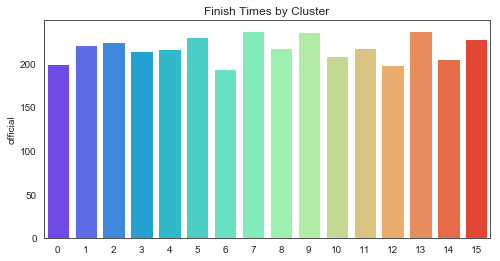

In [44]:
# Let's make some graphs to see which clusters have which characteristics.
off_stats = boston2013.groupby(['clusters'], as_index=False).mean()['official']
off_graph = sns.barplot(off_stats.index, off_stats, palette='rainbow')
off_graph.figure.set_size_inches(8,4)
off_graph.set_title("Finish Times by Cluster");

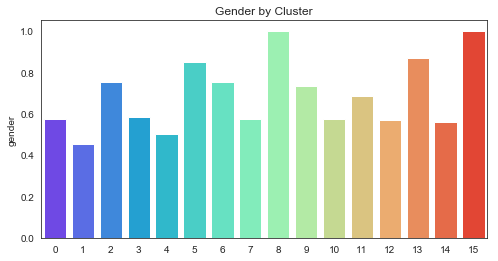

In [45]:
gen_stats = boston2013.groupby(['clusters'], as_index=False).mean()['gender']
gen_graph = sns.barplot(gen_stats.index, gen_stats, palette='rainbow')
gen_graph.figure.set_size_inches(8,4)
gen_graph.set_title("Gender by Cluster");

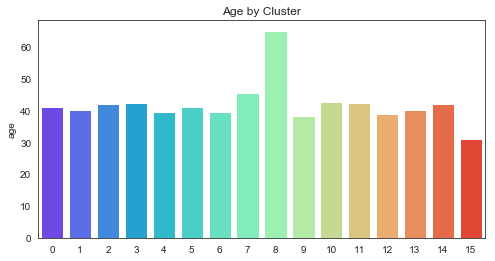

In [46]:
age_stats = boston2013.groupby(['clusters'], as_index=False).mean()['age']
age_graph = sns.barplot(age_stats.index, age_stats, palette='rainbow')
age_graph.figure.set_size_inches(8,4)
age_graph.set_title("Age by Cluster");

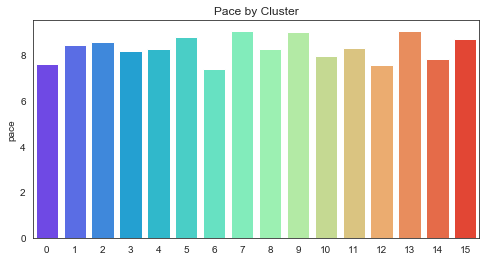

In [47]:
pace_stats = boston2013.groupby(['clusters'], as_index=False).mean()['pace']
pace_graph = sns.barplot(pace_stats.index, pace_stats, palette='rainbow')
pace_graph.figure.set_size_inches(8,4)
pace_graph.set_title("Pace by Cluster");

In [48]:
# Pull out clusters that account for less than 1% of population.
outliers = [cluster01, cluster04, cluster06, cluster07,
            cluster08, cluster09, cluster13, cluster15]
outliers_df = pd.concat(outliers)
outliers_df.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,7.875,42.364,0.735,17.837,29.972,57.858,61.039,56.192,100.340,88.077,135.425,223.270,8.524
std,4.549,9.959,0.214,9.067,22.453,48.212,50.925,60.989,67.225,94.451,112.334,14.855,0.566
min,1.000,31.000,0.455,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,193.430,7.388
25%,5.500,39.192,0.554,17.570,7.304,0.000,0.000,0.000,56.468,0.000,0.000,216.761,8.272
50%,7.500,39.769,0.741,21.730,43.581,86.780,90.519,45.712,132.625,79.789,208.585,224.925,8.587
75%,10.000,41.494,0.902,22.743,45.424,91.595,97.722,112.713,148.339,179.263,221.017,236.046,9.011
max,15.000,65.000,1.000,24.530,50.031,102.023,108.240,130.341,161.281,184.430,223.586,237.353,9.061


In [49]:
data = [cluster00, cluster02, cluster03, cluster05, 
        cluster10, cluster11, cluster12, cluster14]
data_df = pd.concat(data)
data_df.describe()

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,7.125,41.545,0.643,23.217,46.484,93.989,99.198,118.449,144.486,172.029,200.089,212.201,8.102
std,5.249,1.217,0.108,0.406,0.662,0.700,0.716,1.055,2.699,5.848,10.051,11.611,0.443
min,0.000,38.894,0.560,22.458,45.198,92.686,97.977,116.626,140.640,164.718,187.691,197.651,7.546
25%,2.750,41.115,0.571,23.009,46.159,93.896,99.050,117.958,142.481,167.498,192.469,203.472,7.769
50%,7.500,42.097,0.579,23.352,46.714,94.164,99.376,118.457,145.120,172.275,199.688,211.771,8.085
75%,11.250,42.274,0.700,23.432,46.905,94.255,99.462,119.240,146.431,175.950,206.377,219.495,8.380
max,14.000,42.557,0.847,23.727,47.235,94.948,100.235,119.768,147.488,180.265,215.553,229.990,8.780


In [50]:
data_df.head(8)

,clusters,age,gender,5k,10k,20k,half,25k,30k,35k,40k,official,pace
0,0,40.917,0.576,23.362,46.597,93.257,98.328,116.626,140.640,164.928,188.862,199.356,7.612
2,2,42.153,0.753,22.861,45.962,94.118,99.425,119.532,147.488,178.217,210.590,224.352,8.565
3,3,42.380,0.583,23.403,46.896,94.948,100.235,119.768,146.132,173.967,202.203,214.623,8.194
5,5,41.181,0.847,22.458,45.198,92.686,97.977,118.286,147.318,180.265,215.553,229.990,8.780
10,10,42.557,0.572,23.343,46.831,94.372,99.575,118.628,144.109,170.584,197.173,208.920,7.976
11,11,42.239,0.683,23.058,46.224,94.109,99.379,119.142,146.136,175.195,204.973,217.876,8.318
12,12,38.894,0.567,23.727,47.235,94.209,99.290,117.499,141.142,164.718,187.691,197.651,7.546
14,14,42.041,0.560,23.521,46.933,94.216,99.373,118.111,142.927,168.355,193.671,204.845,7.821


After looking at the tendencies of the sixteen clusters, I decided to break them into two groups:  outliers (clusters accounting for less than 1% of the total marathon population) and data (the main group). My analysis is consisting of only the eight clusters of data, excluding the outliers. Cluster12 had the fastest official mean time (197.651), was the youngest group (38.894), and had the second most-balanced male-female ratio (56.7% male).  The second fastest cluster, cluster00 (199.356), was also the second youngest group (40.917), and was comparable to cluster12 with its gender ratio (57.6% male). On the other extreme, cluster05 was the slowest group (229.99), had the most lopsided gender ratio (84.7% male), but was the third youngest group (41.181). Similarly, cluster02 was the second slowest (224.352) with the second most lopsided gender ratio (75.3% male) with a similar age distribution (42.153). There does appear to be a general correlation between groups with a more balanced gender ratio performing better for their overall time, which is very strange, since the fastest male runners almost always seem to beat the fastest female runners.